In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("murtozalikhon/brain-tumor-multimodal-image-ct-and-mri")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'brain-tumor-multimodal-image-ct-and-mri' dataset.
Path to dataset files: /kaggle/input/brain-tumor-multimodal-image-ct-and-mri


In [6]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
from PIL import Image
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import torch

In [7]:
# confirm path structure
for subdir, dirs, files in os.walk(path):
  print(f"{subdir} → {len(files)} files")

/kaggle/input/brain-tumor-multimodal-image-ct-and-mri → 0 files
/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset → 0 files
/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor MRI images → 1 files
/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor MRI images/Tumor → 3000 files
/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor MRI images/Healthy → 2000 files
/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor CT scan Images → 1 files
/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor CT scan Images/Tumor → 2318 files
/kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor CT scan Images/Healthy → 2300 files


In [4]:
DATASET_DIR = os.path.join(path, "Dataset")
CT_DIR = os.path.join(DATASET_DIR, "Brain Tumor CT scan Images")

CT_TUMOR_DIR = os.path.join(CT_DIR, "Tumor")
CT_NORMAL_DIR = os.path.join(CT_DIR, "Healthy")

In [8]:
WORKING_DIR = "/kaggle/working"

CT_ALL_IMAGES_DIR = os.path.join(WORKING_DIR, "CT_ALL_IMAGES_DIR")
os.makedirs(CT_ALL_IMAGES_DIR, exist_ok=True)

print(f"Created writable directory: {CT_ALL_IMAGES_DIR}")

def copy_images_to_new_folder(source_dir, destination_dir):
    for filename in os.listdir(source_dir):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            shutil.copy(os.path.join(source_dir, filename), destination_dir)

print("Copying images...")
copy_images_to_new_folder(CT_TUMOR_DIR, CT_ALL_IMAGES_DIR)
copy_images_to_new_folder(CT_NORMAL_DIR, CT_ALL_IMAGES_DIR)

print(f"Done! All images from '{os.path.basename(CT_TUMOR_DIR)}' and "
      f"'{os.path.basename(CT_NORMAL_DIR)}' copied to "
      f"'{CT_ALL_IMAGES_DIR}'.")

Created writable directory: /kaggle/working/CT_ALL_IMAGES_DIR
Copying images...
Done! All images from 'Tumor' and 'Healthy' copied to '/kaggle/working/CT_ALL_IMAGES_DIR'.


In [9]:
WORKING_DIR = "/kaggle/working"
DEBUG = os.path.join(WORKING_DIR, "DEBUG")
os.makedirs(DEBUG, exist_ok=True)

count = 0
for filename in os.listdir(CT_ALL_IMAGES_DIR):
    if count >= 10:
        break

    if filename.lower().endswith((".png", ".jpg", ".jpeg")):
        src = os.path.join(CT_ALL_IMAGES_DIR, filename)
        dst = os.path.join(DEBUG, filename)

        shutil.copy(src, dst)
        count += 1

print("10 sample images copied to:", DEBUG)


10 sample images copied to: /kaggle/working/DEBUG


In [10]:
# Verify the number of files in the new directory
print(f"Total files in {os.path.basename(CT_ALL_IMAGES_DIR)}: {len(os.listdir(CT_ALL_IMAGES_DIR))}")
print(f"Total files in {os.path.basename(DEBUG)}: {len(os.listdir(DEBUG))}")

Total files in CT_ALL_IMAGES_DIR: 4618
Total files in DEBUG: 10


In [11]:
# Verify the tumor and ct scans are in the same folder
def count_images(root):
  stats = {"healthy": 0, "tumor": 0}

  if os.path.isdir(root):
    for f in os.listdir(root):
      if f.lower().endswith((".jpg", ".png", ".jpeg")):
        if "healthy" in f.lower():
          stats["healthy"] += 1
        else:
          stats["tumor"] += 1

  return stats

stats = count_images(CT_ALL_IMAGES_DIR)
stats

{'healthy': 2300, 'tumor': 2318}

# Data Preprocessing

Based on the findings from the data analysis, the first thing that is important to notice is how evenly distributed the tumor and normal scans there are. Therefore, there isn't any imbalance to worry about.

Based on the analysis, we also noticed heavy preprocessing already done to the images due to cropping, resizing, and low-resolution. However, there is still some **inconsistencies** in terms of image sizes. So we will be **resizing** so that each image has the same dimensions for training.

We will also be applying some filters like **CLAHE** and **Gaussian Blur** to make sure the images are more visible to the model.

### Displaying Images

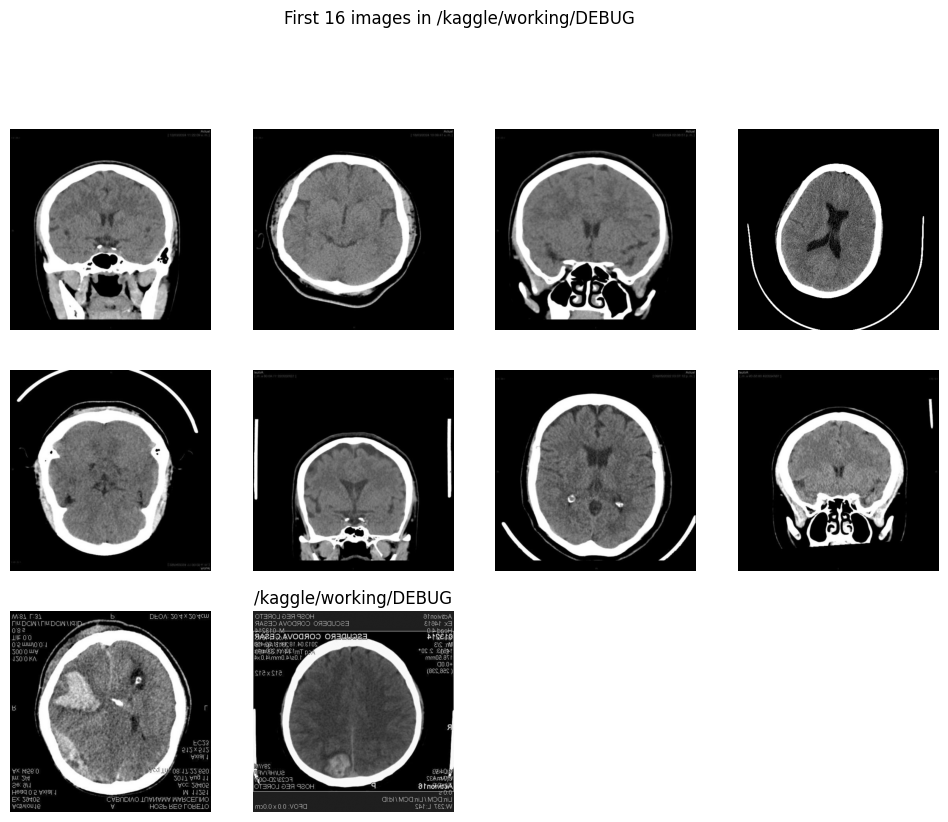

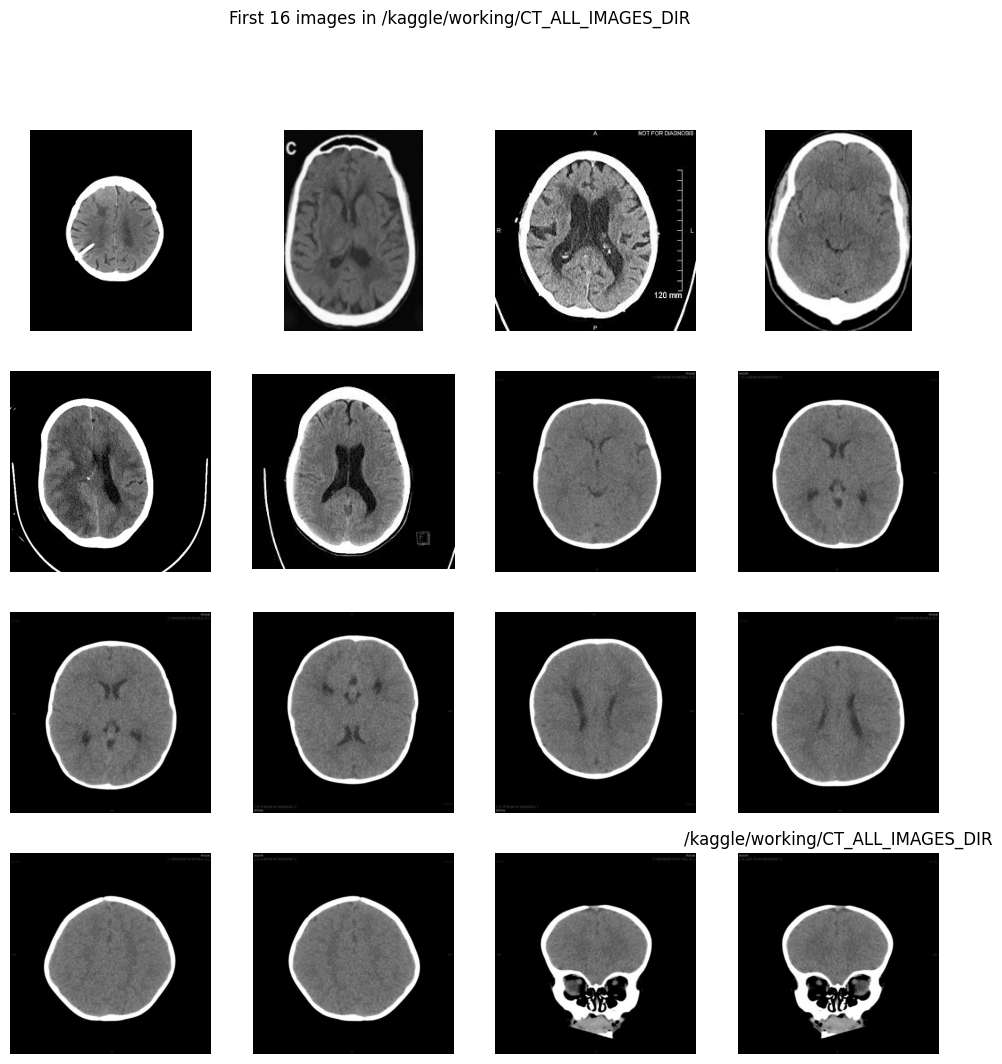

In [12]:
def grid_show(root, n=16):
  images = sorted([
        os.path.join(root, f)
        for f in os.listdir(root)
        if f.lower().endswith((".jpg",".png",".jpeg"))
    ])

  images = images[:n]

  plt.figure(figsize=(12, 12))
  for i, img_path in enumerate(images):
      img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

      plt.subplot(4, 4, i + 1)
      plt.imshow(img, cmap="gray")
      plt.axis('off')

  plt.title(root)
  plt.suptitle(f"First {n} images in {root}")
  plt.show()

grid_show(DEBUG)
grid_show(CT_ALL_IMAGES_DIR)


# Testing Preprocessing Methods

In [13]:
def resize_img(img, size=(224, 224)):
    return img.resize(size, Image.BILINEAR)

def clahe_img(img, clip, tile):
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=tile)
    return clahe.apply(img)

def gaussian_img(img, ksize):
    return cv2.GaussianBlur(img, ksize, 0)

### Resizing Images

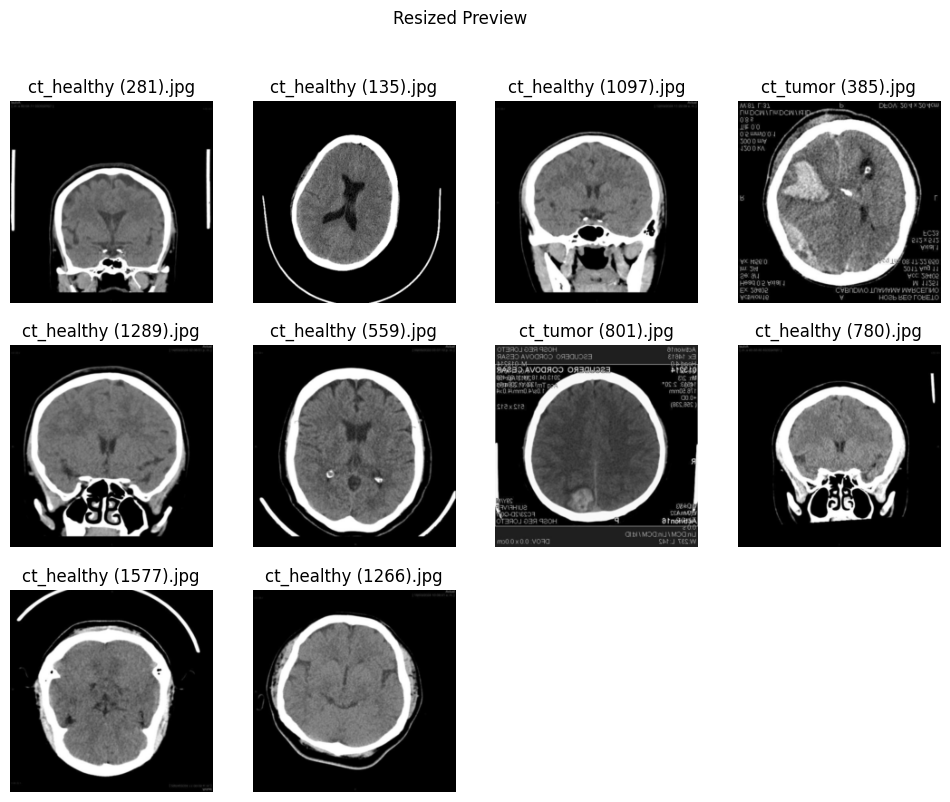

In [14]:
def preview_resized_imgs(folder, target_size=(224, 224), n_cols=4):
    # Collect image paths
    images = [
        os.path.join(folder, f)
        for f in os.listdir(folder)
        if f.lower().endswith((".png", ".jpg", ".jpeg"))
    ]

    # Determine the grid size
    n = len(images)
    n_rows = (n + n_cols - 1) // n_cols

    plt.figure(figsize=(12, 3 * n_rows))

    for i, img_path in enumerate(images):
        img = Image.open(img_path)

        # Resize
        img_resized = img.resize(target_size, Image.BILINEAR)

        # Display
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(img_resized, cmap="gray")
        plt.title(os.path.basename(img_path))
        plt.axis("off")

    plt.suptitle("Resized Preview")
    plt.show()

preview_resized_imgs(DEBUG)

In [19]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

def preview_clahe_settings(img_path, clip_limits=(1.0, 2.0, 4.0), tile_grid_size=(8, 8)):
    """
    Displays original + CLAHE outputs for multiple clip limits.
    img_path: path to image file
    clip_limits: iterable of clipLimit values to try
    tile_grid_size: CLAHE tileGridSize
    """
    if img_path is None:
        raise ValueError("img_path is None. Did you find a healthy/tumor file in DEBUG?")

    if not os.path.exists(img_path):
        raise FileNotFoundError(f"File not found: {img_path}")

    # Read grayscale
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"cv2.imread failed for: {img_path}")

    # Ensure numeric dtype
    img = np.asarray(img)
    if img.dtype == object:
        img = img.astype(np.uint8)

    ncols = 1 + len(clip_limits)
    plt.figure(figsize=(4 * ncols, 4))
    plt.suptitle(f"CLAHE Preview: {os.path.basename(img_path)}", y=1.02)

    # Original
    plt.subplot(1, ncols, 1)
    plt.imshow(img, cmap="gray", vmin=0, vmax=255)
    plt.title("Original")
    plt.axis("off")

    # CLAHE variations
    for i, clip in enumerate(clip_limits):
        clahe = cv2.createCLAHE(clipLimit=float(clip), tileGridSize=tile_grid_size)
        processed = clahe.apply(img)

        plt.subplot(1, ncols, i + 2)
        plt.imshow(processed, cmap="gray", vmin=0, vmax=255)
        plt.title(f"CLAHE clip={clip}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


Healthy sample: /kaggle/working/DEBUG/ct_healthy (281).jpg
Tumor sample: /kaggle/working/DEBUG/ct_tumor (385).jpg


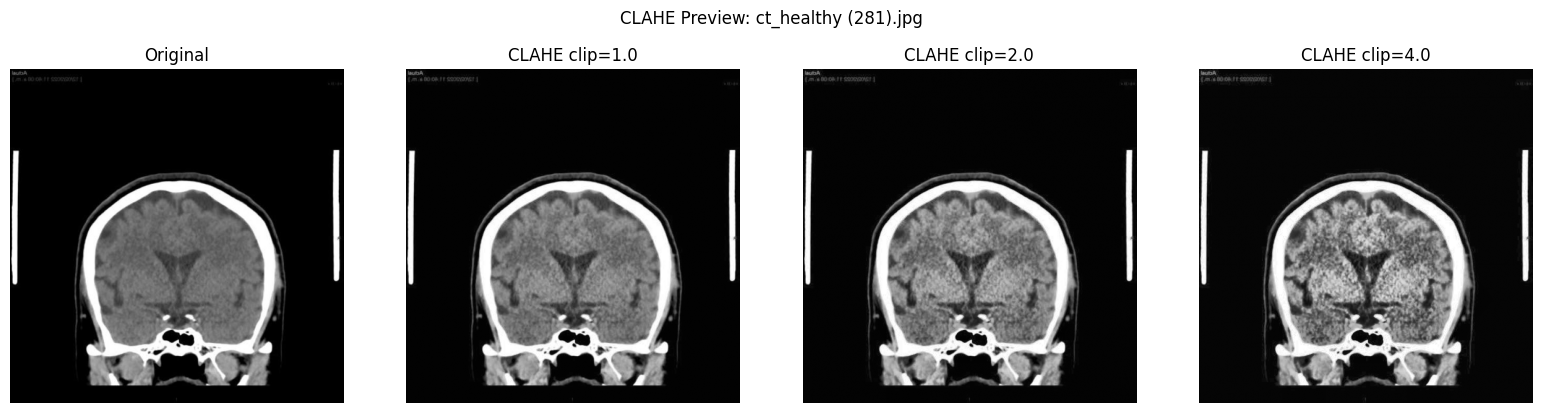

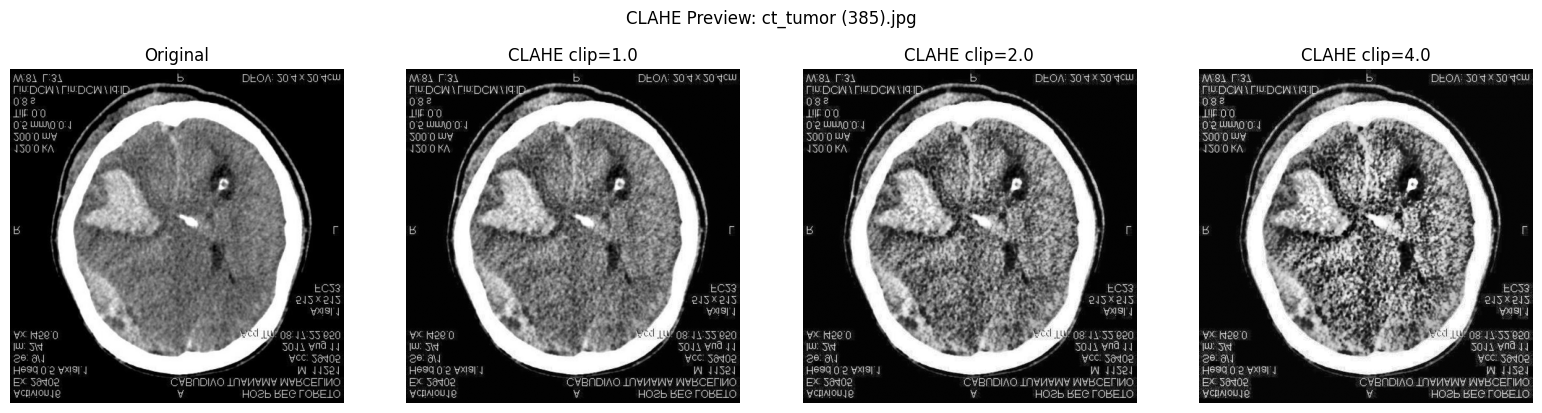

In [20]:
debug_files = os.listdir(DEBUG)

healthy = None
tumor = None

for f in debug_files:
    lower = f.lower()
    if healthy is None and "healthy" in lower:
        healthy = os.path.join(DEBUG, f)
    elif tumor is None and "tumor" in lower:
        tumor = os.path.join(DEBUG, f)

# Safety check
print("Healthy sample:", healthy)
print("Tumor sample:", tumor)

preview_clahe_settings(healthy)
preview_clahe_settings(tumor)

### Gaussian Blur
- One thing that Gaussian Blur can help with is when dealing with scans with texts. It can help make them less apparent.

FILE: ct_healthy (281).jpg


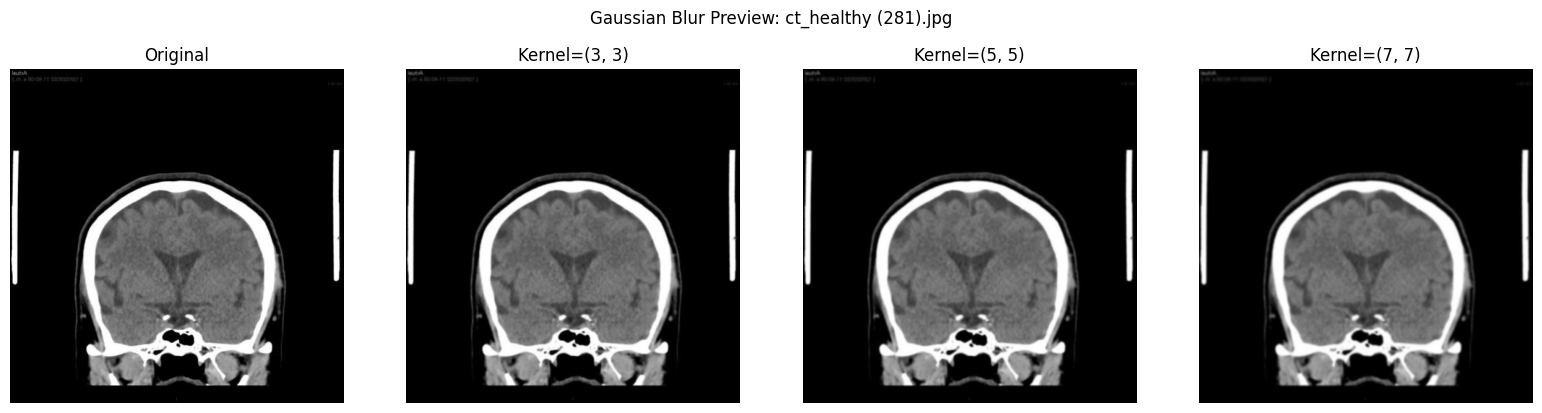

FILE: ct_tumor (385).jpg


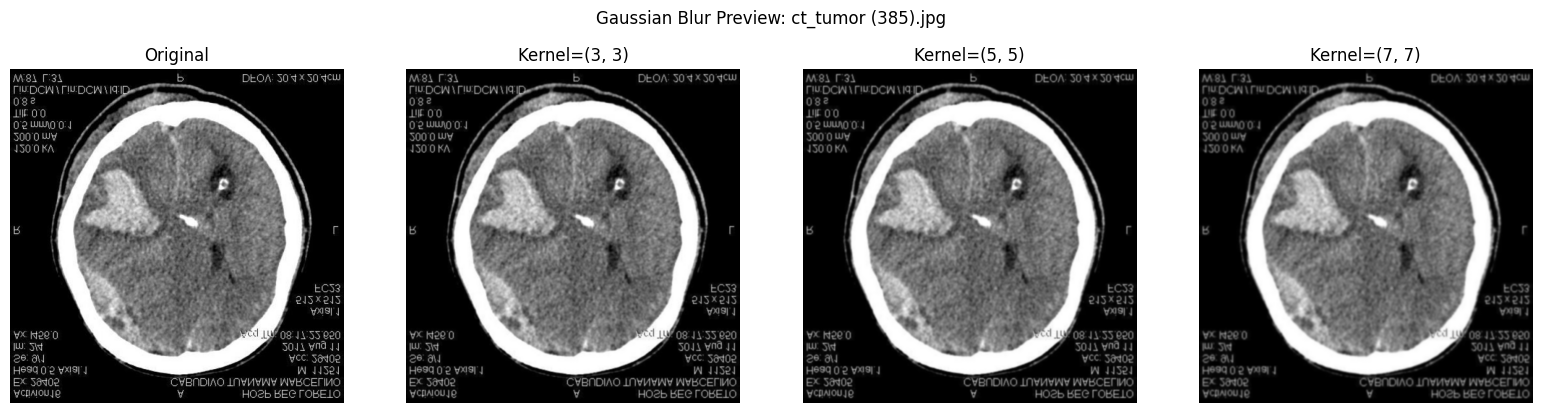

In [25]:
debug_files = os.listdir(DEBUG)

healthy = None
tumor = None

for f in debug_files:
    lower = f.lower()
    if healthy is None and "healthy" in lower:
        healthy = os.path.join(DEBUG, f)
    elif tumor is None and "tumor" in lower:
        tumor = os.path.join(DEBUG, f)



def preview_gaussian_settings(img_path, kernels=((3,3), (5,5), (7,7))):
    """
    Displays original + Gaussian blur outputs for multiple kernel sizes.
    """
    if img_path is None:
        raise ValueError("img_path is None. Make sure your file path is correct.")

    if not os.path.exists(img_path):
        raise FileNotFoundError(f"File not found: {img_path}")

    fname = os.path.basename(img_path)
    print("FILE:", fname)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"cv2.imread failed for: {img_path}")

    img = np.asarray(img)
    if img.dtype == object:
        img = img.astype(np.uint8)

    ncols = 1 + len(kernels)
    plt.figure(figsize=(4 * ncols, 4))
    plt.suptitle(f"Gaussian Blur Preview: {fname}", y=1.02)

    # Original
    plt.subplot(1, ncols, 1)
    plt.imshow(img, cmap="gray", vmin=0, vmax=255)
    plt.title("Original")
    plt.axis("off")

    # Gaussian variations
    for i, krnl in enumerate(kernels):
        gauss = cv2.GaussianBlur(img, krnl, 0)

        plt.subplot(1, ncols, i + 2)
        plt.imshow(gauss, cmap="gray", vmin=0, vmax=255)
        plt.title(f"Kernel={krnl}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

preview_gaussian_settings(healthy)
preview_gaussian_settings(tumor)

# Combinations

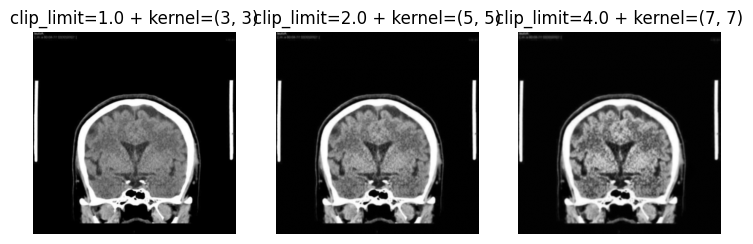

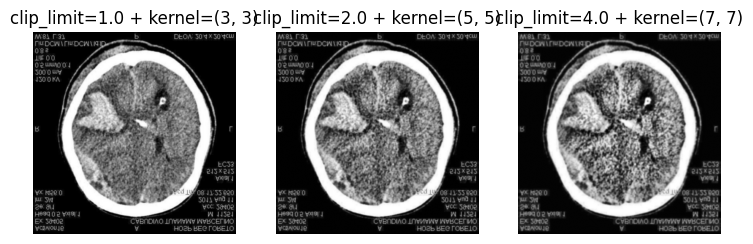

In [26]:
def clahe_then_gauss(img_path, clip_limits=[1.0, 2.0, 4.0], kernel_sizes=[(3,3), (5,5), (7,7)]):
  img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

  plt.figure(figsize=(12, 4))

  for i in range(len(clip_limits)):
    clahe = cv2.createCLAHE(clipLimit=clip_limits[i], tileGridSize=(8,8))
    img_clahe = clahe.apply(img)
    img_gauss = cv2.GaussianBlur(img_clahe, kernel_sizes[i], 0)

    plt.subplot(1, len(clip_limits)+1, i+2)
    plt.imshow(img_gauss, cmap="gray")
    plt.title(f"clip_limit={clip_limits[i]} + kernel={kernel_sizes[i]}")
    plt.axis("off")

clahe_then_gauss(healthy)
clahe_then_gauss(tumor)

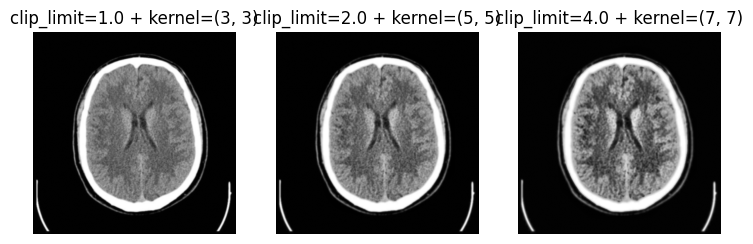

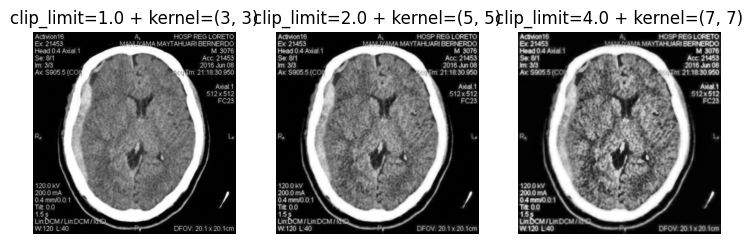

In [ ]:
def gauss_then_clahe(img_path, clip_limits=[1.0, 2.0, 4.0], kernel_sizes=[(3,3), (5,5), (7,7)]):
  img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

  plt.figure(figsize=(12, 4))

  for i in range(len(clip_limits)):
    img_gauss = cv2.GaussianBlur(img, kernel_sizes[i], 0)
    clahe = cv2.createCLAHE(clipLimit=clip_limits[i], tileGridSize=(8,8))
    img_clahe = clahe.apply(img_gauss)


    plt.subplot(1, len(clip_limits)+1, i+2)
    plt.imshow(img_clahe, cmap="gray")
    plt.title(f"clip_limit={clip_limits[i]} + kernel={kernel_sizes[i]}")
    plt.axis("off")

gauss_then_clahe(healthy)
gauss_then_clahe(tumor)

Based on the order of CLAHE and Gaussian Blur, it seems CLAHE before Gaussian blur helps minimize the view of the text on the images.

In [ ]:
# create dataframe of ct images with labels (healthy / tumor)
from typing import List, Tuple

# make sure ct_dir is a valid directory
assert os.path.isdir(CT_ALL_IMAGES_DIR), f"Missing CT directory: {CT_ALL_IMAGES_DIR }"

def list_images_with_label(root_dir: str, label_dirs: List[str]) -> pd.DataFrame:
  rows = []
  for f in os.listdir(root_dir):
    if f.lower().endswith((".jpg", ".jpeg", ".png")):
      lower = f.lower()
      if "healthy" in lower:
          label = "healthy"
      elif "tumor" in lower:
          label = "tumor"
      rows.append({
          "path": os.path.join(root_dir, f),
          "label": label
      })
  return pd.DataFrame(rows)

ct_df = list_images_with_label(CT_ALL_IMAGES_DIR , ["Healthy", "Tumor"])
print("CT images:", len(ct_df))
ct_df.head()

CT images: 4618


path    label
0  /kaggle/working/CT_ALL_IMAGES_DIR/ct_tumor (42...    tumor
1  /kaggle/working/CT_ALL_IMAGES_DIR/ct_tumor (13...    tumor
2  /kaggle/working/CT_ALL_IMAGES_DIR/ct_tumor (35...    tumor
3  /kaggle/working/CT_ALL_IMAGES_DIR/ct_healthy (...  healthy
4  /kaggle/working/CT_ALL_IMAGES_DIR/ct_healthy (...  healthy